In [136]:
import pandas
from transformers import pipeline
import math
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,f1_score,accuracy_score
import numpy as np


In [122]:
classifier = pipeline("zero-shot-classification", model="roberta-large-mnli", device=0, batch_size=10)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [123]:
candidate_labels = ["finance", "apparel and fashion", "food and dining", "health and medicine", 
                    "tech and electronics", "entertainment", "home and garden", "science and environment",
                    "government and politics", "apparel", ]
                    # "career", "banking and payments", 
                    # "sports", "personal care and beauty", "travel", "real estate", 
                    # "investment", "automotive", "consumer electronics", "social", 
                    # "sports fan", "restaurants and dining", "shoes", "casual apparel", 
                    # "cooking and recipes", "education" ]

In [134]:
def get_df(filename, headers):
    df_read = pandas.read_csv(filename, delimiter='\x01', header=0, names=headers, error_bad_lines=False)
    df = df_read[df_read['snippet'].apply(lambda x: isinstance(x,str) )]
    return df


def get_df_with_prediction(count, df, inp_columns):
    small_df = df.take([x for x in range(0,count)])
    arr_pred_multi_class = []
    arr_pred = []
    it = 1
    for id in small_df.index:
        print(it, end = " ")
        it +=1
        sequence = " ".join([small_df[col][id] for col in inp_columns])
        pred = classifier(sequence, candidate_labels)
        arr_pred.append(pred)
        pred_multi = classifier(sequence, candidate_labels, multi_label=True)
        arr_pred_multi_class.append(pred_multi)
    small_df['pred_multi_class'] = arr_pred_multi_class
    small_df['pred'] = arr_pred
    return small_df

def _color_red_or_green(val):
    
    color = 'black' if isinstance(val, str) else 'red' if val < 0 else 'green'
    return 'color: %s' % color

def metrics(topic, y_true, y_pred, y_prob=None):        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    metric_map = {
        'topic': topic,
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'accuracy': acc,        
        'true negative':tn, 
        'false positive': fp,
        'false negative': fn,
        'true positive': tp,

    }
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)
        metric_map['auc'] = auc_score
    return metric_map
    

def evaluate(small_df, label_col="label"):
    result = {}
    for topic in candidate_labels:
        result[topic] = {"y_true":[], "y_pred":[], "y_pred_1":[], "y_prob":[]}
    for id in small_df.index:
        labels = [x.replace("_"," ") for x in small_df[label_col][id].split("\x02")]
        pred = small_df["pred"][id]
        output = pred['labels']
        pred_multi_class = small_df["pred_multi_class"][id]            
        for topic in candidate_labels:
            result[topic]["y_true"].append(1 if topic in labels else 0)
            result[topic]["y_pred_1"].append(1 if topic in output[0:3] else 0)
            y_prob = pred_multi_class['scores'][pred_multi_class['labels'].index(topic)] if topic in pred_multi_class['labels'] else 0.0
            result[topic]["y_prob"].append(y_prob)
            result[topic]["y_pred"].append(y_prob>0.3)                
                
                
    eval_result = []
    eval_result_1 = []    
    for topic in result.keys():
        eval_result.append(
            metrics(
                topic,
                result[topic]["y_true"], 
                result[topic]["y_pred"], 
                result[topic]["y_prob"]
            )
        )
        eval_result_1.append(
            metrics(
                topic,
                result[topic]["y_true"], 
                result[topic]["y_pred_1"]
            )
        )
    eval_df = pandas.DataFrame(eval_result)
    eval_df1 = pandas.DataFrame(eval_result_1)    
    return (eval_df, eval_df1)

In [125]:
df_2 = get_df("sample2", ['xcluster','guid','immutable_id','subject','fromname','content','snippet','topics','rnk'])

/var/tmp/ipykernel_101083/2041789.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_read = pandas.read_csv(filename, delimiter='\x01', header=0, names=headers, error_bad_lines=False)
Skipping line 1786: expected 9 fields, saw 10
Skipping line 9495: expected 9 fields, saw 10
Skipping line 25163: expected 9 fields, saw 11
Skipping line 31456: expected 9 fields, saw 12



In [126]:
small_df_10000 = get_df_with_prediction(10000, df_2, ["subject","fromname","content"])

1 2 3 4 5 6 

/opt/conda/lib/python3.10/site-packages/transformers/pipelines/base.py:1081: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 

In [127]:
small_df_10000.to_pickle("small_df_10000")

In [129]:
small_df_10000

,xcluster,guid,immutable_id,subject,fromname,content,snippet,topics,rnk,pred_multi_class,pred
0,alerts.trulia.com::516150d1b5feeecf::1,X6H67AJ7ZCRLUOHQJ56SW2QZ64,AIdLBbx_WTNQZHqKBQ3qgA3N8is,"New home in Leander, TX at $399,900",Trulia,96 new listings from trulia 1005 clear lake ln...,"1005 Clear Lake Ln, Leander, TX. 3bd, 2ba, 1,7...",real_estate,5.0,"{'sequence': 'New home in Leander, TX at $399,...","{'sequence': 'New home in Leander, TX at $399,..."
1,account.chime.com::b2e73bbaf16a0bec::1,5SJH63YRPCPJM453UWXDP3542I,ACACBrFSrOZnZHuUwQrlEGuKCFQ,⚡ Your instant transfer arrived ⚡,Chime,chime the funds have been transferred to your ...,The funds have been transferred to your Chime ...,financebanking_and_payments,5.0,{'sequence': '⚡ Your instant transfer arrived ...,{'sequence': '⚡ Your instant transfer arrived ...
2,daily.triviaclick.com::ea090f61ac207c0a::1,3WFUTBFL7X3JNCTVOZLZLBGJC4,AJC3_EBE-7PAZHsvVgQayLWwbl8,🧠 Put Your Brain to the Test With Trivia,Trivia Click,triviaclick new design answer today's question...,Answer today’s question! How many members make...,entertainmentgames,5.0,{'sequence': '🧠 Put Your Brain to the Test Wit...,{'sequence': '🧠 Put Your Brain to the Test Wit...
3,info.frontpoint.com::fb8f8e6e34f14639::1,LLNKCFDZ2IDYVZFFONIVCRPGDM,AH6-aJoE7SHZZHtIpARhGFPERiU,Save 25% on smart home security + FREE ground ...,Frontpoint,96 frontpoint get secure with packages startin...,Get secure with packages starting at $129 | Vi...,home_and_gardenutilities_and_managementtech_...,5.0,{'sequence': 'Save 25% on smart home security ...,{'sequence': 'Save 25% on smart home security ...
4,pharmacy.cvs.com::18fc3e237906e14d::1,OLSA2AHCS6XALAHPTU6J3VKQHM,AIXWQBIAXzRcZHvBkgsvSJkDjhM,"Shoshana, Congrats! You saved 30%.",CVS ExtraCare,cvs 96 that means extra savings on something y...,That means extra savings on something you need...,health_and_medicine,5.0,"{'sequence': 'Shoshana, Congrats! You saved 30...","{'sequence': 'Shoshana, Congrats! You saved 30..."
...,...,...,...,...,...,...,...,...,...,...,...
9995,many-mail.io::cdfe3f00b3dd91be::1,TLH5SAPSVPWQO6RRUSUTMZQYEI,AA2QiesSLqdqZHteqAIPWI5VClE,Presto Cannedy There Are Several Choices Avail...,Christine Smith,96 deposit is ready & available today hello pr...,Deposit is Ready & Available Today Hello Prest...,financemortgage_and_loans,5.0,{'sequence': 'Presto Cannedy There Are Several...,{'sequence': 'Presto Cannedy There Are Several...
9996,wish.com::843c0514006acff0::1,25FIEWXLSFJVCHKKNO66YNAT7E,AHzkRvtpeQnxZHtfhw2cYDTWhv8,Nightlights + your wishlist = joy 🌟,Wish,"nightlights + your wishlist = joy 🌟 hi steven,...","Hi Steven, Nightlights + your wishlist = joy 🌟...",home_and_gardentech_and_electronicsconsumer_...,5.0,{'sequence': 'Nightlights + your wishlist = jo...,{'sequence': 'Nightlights + your wishlist = jo...
9997,chocolate.lindtusa.com::b27b57bc1777bc5f::1,YKDBV5AC45D74VOINSSNAO4MKA,APKf3hh5fdpTZHs9hwyyAIacDqI,"Brigitta, shop 25% off select gifts perfect fo...",Lindt Chocolate,"brigitta, shop 25% off select gifts perfect fo...",Explore our curated arrangement of dad-approve...,food_and_dininggrocery,5.0,"{'sequence': 'Brigitta, shop 25% off select gi...","{'sequence': 'Brigitta, shop 25% off select gi..."
9998,gmail.com::14c65950bec2d3a0::1,J3MHOZCC67B5LMAKTJTLQ2BE6Q,AKcbqgN14WozZHq3mQxQWCrpDjI,Upgrade Your Car's Exhaust Systems!,ECCPP AutoParts,interior exterior performance lighting wheels ...,Interior Exterior Performance Lighting Wheels ...,automotive,5.0,{'sequence': 'Upgrade Your Car's Exhaust Syste...,{'sequence': 'Upgrade Your Car's Exhaust Syste...


In [137]:
(eval_df, eval_df1) = evaluate(small_df_10000[small_df_10000['topics'].apply(lambda x: isinstance(x,str))], label_col="topics")

eval_df\
.style\
.format(precision=2) \
.set_properties(**{'color': 'red'}, subset=['false negative', 'false positive'])\
.set_properties(**{'color': 'green'}, subset=['true negative', 'true positive'])


,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive,auc
0,finance,0.20,0.72,0.31,0.49,3684,4690,448,1176,0.60
1,apparel and fashion,0.21,0.82,0.34,0.58,4715,3979,231,1073,0.77
2,food and dining,0.15,0.85,0.25,0.60,5331,3872,117,678,0.82
3,health and medicine,0.13,0.80,0.23,0.59,5233,3990,155,620,0.76
4,tech and electronics,0.11,0.78,0.19,0.50,4404,4857,163,574,0.71
5,entertainment,0.09,0.86,0.17,0.38,3179,6099,101,619,0.69
6,home and garden,0.09,0.72,0.17,0.50,4459,4841,198,500,0.64
7,science and environment,0.05,0.40,0.10,0.53,5041,4338,370,249,0.52
8,government and politics,0.09,0.78,0.15,0.48,4313,5071,137,477,0.70
9,apparel,0.08,0.86,0.15,0.44,3917,5508,78,495,0.71


In [138]:
eval_df1\
.style\
.format(precision=2) \
.set_properties(**{'color': 'red'}, subset=['false negative', 'false positive'])\
.set_properties(**{'color': 'green'}, subset=['true negative', 'true positive'])


,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive
0,finance,0.26,0.80,0.40,0.60,4731,3643,318,1306
1,apparel and fashion,0.75,0.57,0.64,0.92,8444,250,565,739
2,food and dining,0.60,0.70,0.65,0.94,8837,366,238,557
3,health and medicine,0.54,0.68,0.60,0.93,8780,443,247,528
4,tech and electronics,0.19,0.61,0.29,0.78,7369,1892,290,447
5,entertainment,0.09,0.93,0.16,0.30,2305,6973,50,670
6,home and garden,0.10,0.57,0.18,0.63,5897,3403,299,399
7,science and environment,0.05,0.08,0.06,0.84,8372,1007,571,48
8,government and politics,0.22,0.70,0.33,0.83,7850,1534,187,427
9,apparel,0.09,0.80,0.15,0.50,4521,4904,115,458


In [135]:
small_df_2 = get_df_with_prediction(1000, df_2, ["subject","fromname","content"])

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 

In [138]:
small_df_2.to_pickle("small_df_1000")

In [213]:
(eval_df, eval_df1) = evaluate(small_df_2, label_col="topics")

eval_df\
.style\
.format(precision=2) \
.set_properties(**{'color': 'red'}, subset=['false negative', 'false positive'])\
.set_properties(**{'color': 'green'}, subset=['true negative', 'true positive'])


,topic,precision,recall,f1_score,true negative,false positive,false negative,true positive,auc
0,finance,0.21,0.69,0.32,355,468,55,122,0.59
1,apparel and fashion,0.21,0.83,0.34,486,388,21,105,0.78
2,food and dining,0.13,0.86,0.22,539,395,9,57,0.82
3,health and medicine,0.13,0.80,0.23,532,392,15,61,0.77
4,tech and electronics,0.11,0.80,0.19,448,478,15,59,0.75
5,entertainment,0.08,0.84,0.14,321,616,10,53,0.72
6,home and garden,0.09,0.72,0.15,446,490,18,46,0.65
7,science and environment,0.06,0.38,0.10,502,429,43,26,0.54
8,government and politics,0.10,0.85,0.18,426,508,10,56,0.73
9,apparel,0.08,0.84,0.15,400,542,9,49,0.73


In [214]:
eval_df1\
.style\
.format(precision=2) \
.set_properties(**{'color': 'red'}, subset=['false negative', 'false positive'])\
.set_properties(**{'color': 'green'}, subset=['true negative', 'true positive'])


,topic,precision,recall,f1_score,true negative,false positive,false negative,true positive
0,finance,0.28,0.80,0.41,458,365,36,141
1,apparel and fashion,0.77,0.52,0.62,854,20,60,66
2,food and dining,0.57,0.73,0.64,898,36,18,48
3,health and medicine,0.54,0.62,0.58,884,40,29,47
4,tech and electronics,0.19,0.59,0.29,742,184,30,44
5,entertainment,0.08,0.95,0.14,212,725,3,60
6,home and garden,0.09,0.55,0.15,580,356,29,35
7,science and environment,0.08,0.13,0.10,826,105,60,9
8,government and politics,0.25,0.74,0.38,788,146,17,49
9,apparel,0.08,0.72,0.14,460,482,16,42


In [219]:
import tensorflow as tf
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
pipe = pipeline("text-classification")
pipe("This restaurant is awesome")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


[{'label': 'POSITIVE', 'score': 0.9998743534088135}]

In [16]:
pipe = pipeline(model="roberta-large-mnli", device=0)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:

pipe(["This restaurant is awesome","This product is not good", "Apple launched vision pro"], batch_size=3)

[{'label': 'NEUTRAL', 'score': 0.7313141822814941},
 {'label': 'NEUTRAL', 'score': 0.5708449482917786},
 {'label': 'NEUTRAL', 'score': 0.500408411026001}]

In [6]:
pipe = pipeline("text-classification")
pipe(["This restaurant is awesome", "This restaurant is awful"])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998743534088135},
 {'label': 'NEGATIVE', 'score': 0.9996669292449951}]

In [43]:
from transformers import AutoTokenizer, AutoModel
from torch.nn import functional as F
tokenizer = AutoTokenizer.from_pretrained("")

ImportError: /opt/conda/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so: undefined symbol: cudaGraphInstantiateWithFlags, version libcudart.so.11.0

In [42]:
from transformers import BartForSequenceClassification, BartTokenizer
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-mnli")
model = BartForSequenceClassification.from_pretrained("facebook/bart-large-mnli")


RuntimeError: Failed to import transformers.models.bart.modeling_bart because of the following error (look up to see its traceback):
/opt/conda/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so: undefined symbol: cudaGraphInstantiateWithFlags, version libcudart.so.11.0

In [40]:
premise = "Who are you voting in 2020?"
hypothesis = ["This is related to politics", "This is related to art", "This is related to science"]

In [41]:
# c = []
# for h in hypothesis:
#     c.append(tokenizer.encode(premise, h, return_tensors='pt'))



input_ids = tokenizer.encode(premise, hypothesis[0], return_tensors='pt')


NameError: name 'tokenizer' is not defined

In [114]:
logits = model(input_ids)[0]
logits[:, [0,2]].softmax(dim=1)[:,1].item()*100

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'new_zeros'

In [34]:
a = logits[:, [0,2]]

In [37]:
probs = a.softmax(dim=1)

In [39]:
true_prob = probs[:,1].item()*100

In [40]:
true_prob

99.28499460220337

In [44]:
small_df_2_imp = pandas.read_pickle("small_df_1000")

In [60]:
np.histogram(small_df_2_imp['content'].apply(x)

SyntaxError: incomplete input (3176985341.py, line 1)

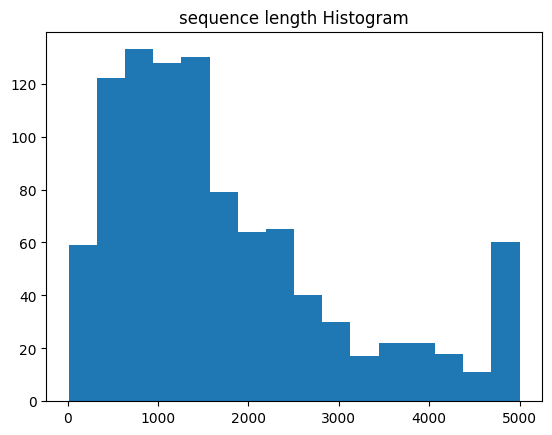

In [74]:
import matplotlib.pyplot as plt
a = np.hstack(small_df_2_imp['content'].apply(lambda x: len(x)))
_ = plt.hist(a, bins='auto')  # arguments are passed to np.histogram
plt.title("sequence length Histogram")
plt.show()

In [71]:
for index, row in df.iterrows():
    print(row['c1'], row['c2'])

TypeError: <lambda>() missing 2 required positional arguments: 'y' and 'z'

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from datasets import load_dataset
from collections import Counter
import tensorflow_text
import tensorflow_hub as hub

import pandas

In [16]:
tfhub_handle_encoder="https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_handle_preprocess="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

2023-06-12 16:42:41.526583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-12 16:42:41.527213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-12 16:42:41.527372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'seq_length' with dtype int32
	 [[{{node seq_length}}]]
2023-06-12 16:42:41.527890: I tensorflow/core/

In [17]:
tokens = bert_preprocess_model(["Who are you voting in 2020?"])
tokens

{'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
 array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 

In [19]:
seq = bert_model(tokens)['pooled_output']

In [33]:
h_1 = bert_model(bert_preprocess_model(["politics"]))['pooled_output']
h_2 = bert_model(bert_preprocess_model(["finance"]))['pooled_output']
h_3 = bert_model(bert_preprocess_model(["art"]))['pooled_output']

In [34]:
np.dot(seq[0], h_1[0])/512

0.36713194847106934

In [35]:
np.dot(seq[0], h_2[0])/512

0.34136059880256653

In [36]:
np.dot(seq[0], h_3[0])/512

0.35313206911087036

In [37]:
from scipy.spatial import distance

In [38]:
distance.cosine(seq[0], h_3[0])

0.1889076828956604

In [39]:
distance.cosine(seq[0], h_1[0])

0.178955078125

## USE Model

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas
from sklearn.metrics import confusion_matrix,precision_score,recall_score,roc_curve,auc,f1_score,accuracy_score
import numpy as np


candidate_labels = ["finance", "apparel and fashion", "food and dining", "health and medicine", 
                    "tech and electronics", "entertainment", "home and garden", "science and environment",
                    "government and politics", "apparel", ]
                    # "career", "banking and payments", 
                    # "sports", "personal care and beauty", "travel", "real estate", 
                    # "investment", "automotive", "consumer electronics", "social", 
                    # "sports fan", "restaurants and dining", "shoes", "casual apparel", 
                    # "cooking and recipes", "education" ]

2023-06-12 18:18:33.215589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarni

In [2]:
model = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

2023-06-12 18:18:42.428182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:18:42.434348: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-12 18:18:42.435969: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
input_embedding = model(["Who are you voting in 2020?"])[0]

label_embeddings = model(candidate_labels)
scores = tf.reduce_sum(input_embedding * label_embeddings, axis=1)

# label_scores = dict(zip(candidate_labels, scores.numpy()))
scores.numpy()


array([ 0.029844  , -0.05816384, -0.07609773, -0.02770378, -0.05365713,
       -0.06250247, -0.12026697, -0.0209319 ,  0.08021943, -0.06764548],
      dtype=float32)

In [31]:
def get_df(filename, headers):
    df_read = pandas.read_csv(filename, delimiter='\x01', header=0, names=headers, error_bad_lines=False)
    df = df_read[df_read['snippet'].apply(lambda x: isinstance(x,str) )]
    return df


def get_df_with_prediction(count, df, inp_columns):
    small_df = df.take([x for x in range(0,count)])
    arr_pred = []
    it = 1
    for id in small_df.index:
        print(it, end = " ")
        it +=1
        sequence = " ".join([small_df[col][id] for col in inp_columns])
        input_embedding = model([sequence])[0]
        label_embeddings = model(candidate_labels)
        scores = tf.reduce_sum(input_embedding * label_embeddings, axis=1)
        arr_pred.append(scores.numpy())
    small_df['pred'] = arr_pred
    return small_df


def metrics(topic, y_true, y_pred, y_prob=None):        
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    metric_map = {
        'topic': topic,
        'precision': precision, 
        'recall': recall, 
        'f1_score': f1, 
        'accuracy': acc,        
        'true negative':tn, 
        'false positive': fp,
        'false negative': fn,
        'true positive': tp,

    }
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_true, y_prob)
        auc_score = auc(fpr, tpr)
        metric_map['auc'] = auc_score
    return metric_map
    

def evaluate(small_df, label_col="label", threshold=0.0):
    result = {}
    for topic in candidate_labels:
        result[topic] = {"y_true":[], "y_pred":[], "y_pred_1":[], "y_prob":[]}
    for id in small_df.index:
        labels = [x.replace("_"," ") for x in small_df[label_col][id].split("\x02")]
        pred = small_df["pred"][id]
        for i,topic in enumerate(candidate_labels):
            result[topic]["y_true"].append(1 if topic in labels else 0)
            result[topic]["y_prob"].append(pred[i])
            result[topic]["y_pred"].append(pred[i]>threshold)                
                
                
    eval_result = []
    eval_result_1 = []    
    for topic in result.keys():
        eval_result.append(
            metrics(
                topic,
                result[topic]["y_true"], 
                result[topic]["y_pred"], 
                result[topic]["y_prob"]
            )
        )
    eval_df = pandas.DataFrame(eval_result)
    return eval_df

In [6]:
df_2 = get_df("sample2", ['xcluster','guid','immutable_id','subject','fromname','content','snippet','topics','rnk'])

/var/tmp/ipykernel_212723/2937360642.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_read = pandas.read_csv(filename, delimiter='\x01', header=0, names=headers, error_bad_lines=False)
Skipping line 1786: expected 9 fields, saw 10
Skipping line 9495: expected 9 fields, saw 10
Skipping line 25163: expected 9 fields, saw 11
Skipping line 31456: expected 9 fields, saw 12



In [14]:
small_df_2 = get_df_with_prediction(10000, df_2, ["subject","fromname","content"])

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [15]:
small_df_2

,xcluster,guid,immutable_id,subject,fromname,content,snippet,topics,rnk,pred
0,alerts.trulia.com::516150d1b5feeecf::1,X6H67AJ7ZCRLUOHQJ56SW2QZ64,AIdLBbx_WTNQZHqKBQ3qgA3N8is,"New home in Leander, TX at $399,900",Trulia,96 new listings from trulia 1005 clear lake ln...,"1005 Clear Lake Ln, Leander, TX. 3bd, 2ba, 1,7...",real_estate,5.0,"[-0.0073393546, -0.03733085, -0.0045116544, -0..."
1,account.chime.com::b2e73bbaf16a0bec::1,5SJH63YRPCPJM453UWXDP3542I,ACACBrFSrOZnZHuUwQrlEGuKCFQ,⚡ Your instant transfer arrived ⚡,Chime,chime the funds have been transferred to your ...,The funds have been transferred to your Chime ...,financebanking_and_payments,5.0,"[0.045093812, -0.038831823, -0.04270774, -0.04..."
2,daily.triviaclick.com::ea090f61ac207c0a::1,3WFUTBFL7X3JNCTVOZLZLBGJC4,AJC3_EBE-7PAZHsvVgQayLWwbl8,🧠 Put Your Brain to the Test With Trivia,Trivia Click,triviaclick new design answer today's question...,Answer today’s question! How many members make...,entertainmentgames,5.0,"[0.031374194, 0.06449792, 0.026589911, 0.03631..."
3,info.frontpoint.com::fb8f8e6e34f14639::1,LLNKCFDZ2IDYVZFFONIVCRPGDM,AH6-aJoE7SHZZHtIpARhGFPERiU,Save 25% on smart home security + FREE ground ...,Frontpoint,96 frontpoint get secure with packages startin...,Get secure with packages starting at $129 | Vi...,home_and_gardenutilities_and_managementtech_...,5.0,"[-0.026369922, 0.019186113, 0.027277038, 0.017..."
4,pharmacy.cvs.com::18fc3e237906e14d::1,OLSA2AHCS6XALAHPTU6J3VKQHM,AIXWQBIAXzRcZHvBkgsvSJkDjhM,"Shoshana, Congrats! You saved 30%.",CVS ExtraCare,cvs 96 that means extra savings on something y...,That means extra savings on something you need...,health_and_medicine,5.0,"[-0.07546534, 0.04298699, 0.06707363, 0.096191..."
...,...,...,...,...,...,...,...,...,...,...
9995,many-mail.io::cdfe3f00b3dd91be::1,TLH5SAPSVPWQO6RRUSUTMZQYEI,AA2QiesSLqdqZHteqAIPWI5VClE,Presto Cannedy There Are Several Choices Avail...,Christine Smith,96 deposit is ready & available today hello pr...,Deposit is Ready & Available Today Hello Prest...,financemortgage_and_loans,5.0,"[0.124790564, -0.011270395, 0.00907498, -0.040..."
9996,wish.com::843c0514006acff0::1,25FIEWXLSFJVCHKKNO66YNAT7E,AHzkRvtpeQnxZHtfhw2cYDTWhv8,Nightlights + your wishlist = joy 🌟,Wish,"nightlights + your wishlist = joy 🌟 hi steven,...","Hi Steven, Nightlights + your wishlist = joy 🌟...",home_and_gardentech_and_electronicsconsumer_...,5.0,"[-0.058595, 0.009298114, 0.03489109, 0.0328128..."
9997,chocolate.lindtusa.com::b27b57bc1777bc5f::1,YKDBV5AC45D74VOINSSNAO4MKA,APKf3hh5fdpTZHs9hwyyAIacDqI,"Brigitta, shop 25% off select gifts perfect fo...",Lindt Chocolate,"brigitta, shop 25% off select gifts perfect fo...",Explore our curated arrangement of dad-approve...,food_and_dininggrocery,5.0,"[-0.014445802, 0.032636672, 0.07068718, 0.0510..."
9998,gmail.com::14c65950bec2d3a0::1,J3MHOZCC67B5LMAKTJTLQ2BE6Q,AKcbqgN14WozZHq3mQxQWCrpDjI,Upgrade Your Car's Exhaust Systems!,ECCPP AutoParts,interior exterior performance lighting wheels ...,Interior Exterior Performance Lighting Wheels ...,automotive,5.0,"[-0.033228543, 0.008128654, 0.011273194, 0.032..."


In [33]:
eval_df = evaluate(small_df_2[small_df_2['topics'].apply(lambda x: isinstance(x,str))], label_col="topics", threshold=0.01)

eval_df\
.style\
.format(precision=2) \
.set_properties(**{'color': 'red'}, subset=['false negative', 'false positive'])\
.set_properties(**{'color': 'green'}, subset=['true negative', 'true positive'])

,topic,precision,recall,f1_score,accuracy,true negative,false positive,false negative,true positive,auc
0,finance,0.51,0.78,0.62,0.84,7170,1204,352,1272,0.90
1,apparel and fashion,0.21,0.91,0.34,0.53,4080,4614,113,1191,0.85
2,food and dining,0.13,0.92,0.23,0.50,4302,4901,66,729,0.85
3,health and medicine,0.12,0.89,0.20,0.46,3958,5265,89,686,0.80
4,tech and electronics,0.11,0.73,0.19,0.55,4955,4306,200,537,0.72
5,entertainment,0.21,0.30,0.25,0.87,8491,787,506,214,0.64
6,home and garden,0.09,0.95,0.16,0.32,2554,6746,33,665,0.80
7,science and environment,0.02,0.13,0.04,0.61,6026,3353,540,79,0.32
8,government and politics,0.12,0.75,0.20,0.64,5925,3459,154,460,0.76
9,apparel,0.12,0.95,0.22,0.61,5567,3858,29,544,0.92


In [23]:
small_df_2.to_pickle("small_df_use_10000")

In [30]:
small_df_2[small_df_2['pred'].apply(lambda x: x[3]>0.1)]

,xcluster,guid,immutable_id,subject,fromname,content,snippet,topics,rnk,pred
15,messages.odb.org::ba77365b1def1456::1,LD67KB5PQCRVYLFL2QXNTZ5WQM,AEdwdBE17A5SZHrOSwQPEL3NCLU,The Secret Of The Lord,My Utmost for His Highest - Classic Edition,what is the sign of a friend? that he tells yo...,What is the sign of a friend? That he tells yo...,other,5.0,"[-0.0095077325, 0.041249678, 0.005170891, 0.15..."
17,twr2q.thepreciousflorals.com::7bcc3fffe82b3b39::1,YNJ5XAUBGMDUYMLOQKPXHUHQDA,AN6sqkVh3XJRZHuPfwwGIF196Pg,Surgery Partners Inc.,Goodbye Town,trending on internet today - by thepreciousflo...,"Today's Trending News. June 3rd, 2023 Surgery ...",health_and_medicine,5.0,"[-0.04216838, 0.06747329, 0.020596737, 0.10849..."
52,epochtimes.com::e3716583852ede5b::1,2FHCXB7UCV7JTBQX5KVDXAXJPM,ANlgIJpoVtZnZHslGAwCOE4Dh3o,A Popular Sweetener May Damage DNA: Study,Epoch Health,96 a popular sweetener may damage dna: study a...,A new study on sucralose—a popular sugar-free ...,health_and_medicine,5.0,"[-0.0393669, 0.05862444, 0.08137671, 0.1305393..."
54,ask.mypanter.com::e6685eaff539097a::1,PPG3ZW4CRWYLKJE2DAURI5JJIA,AFak9ng3gfyeZHshCwY12KYr-YU,Introducing Care Supreme- The Health Insurance...,Care Health Insurance,unsubscribe me from this mailing list,Unsubscribe me from this mailing list,financeinsurance,5.0,"[0.021484436, -0.09310163, -0.06555332, 0.1119..."
57,youwealthrevolution.com::0fdb11243bfd64f2::1,LUVV4VHDFSU67IJVP6KD34KQT4,ALfYtqRob6n3ZHuvvQdmiL5FowI,"[Lynn Waldrop GIFT] ❤ Jeremy, Seeking Freedom...",*** Darius Barazandeh | You Wealth Revolutio ***,free gift weekend included* 96 manage subscrip...,Free Gift Weekend Included* Manage Subscriptio...,personal_growth,5.0,"[-0.026349492, 0.061948404, 0.09365535, 0.1943..."
...,...,...,...,...,...,...,...,...,...,...
9944,steppenwolf.org::101a5ef3de54f024::1,PSRB5H5POYZEPWZUWDTRBZUW4Q,AB4IBIUTuv-RZHtBrwa6qAwRbNs,E-News: A Judy Greer Rom-Com Watchlist,Steppenwolf Theatre Company,"steppenwolf 96 laurie metcalf on broadway, kin...","Laurie Metcalf on Broadway, King James in NYC ...",entertainment,5.0,"[0.025789894, 0.084752955, 0.094182424, 0.1092..."
9952,m.visionworks.com::d5a6b501208a4d1a::1,YTIKERACDLCNXZYF7NGRR4OOB4,AHXswQFMoCXlZHtnwQrZWOeQDoo,We have rescheduled your appointment,Visionworks,visionworks can't wait to see you glasses | su...,Can't wait to see you GLASSES | SUNGLASSES | C...,health_and_medicine,5.0,"[-0.0032467712, 0.083462074, 0.05611042, 0.117..."
9953,StocksEarning.com::396620c257f8d44a::1,WJO27BNQA2CXLTCM4WDGOARDBQ,APAjHAILcpIZZHuDrwTaMHtHgLE,Hurry before this expires: claim your Volatili...,SE Options Alert,volatility rush trader the clock’s ticking. wo...,The Clock’s Ticking. Worry free trading when m...,financeinvestment,5.0,"[0.034932252, 0.06259738, -0.0050672684, 0.102..."
9963,pharmacy.cvs.com::434ff5b81fa39c02::1,N5LKD2U6QO22EZRSUGBO2445KM,AMzPAkofrxpsZHrX0A32OH_Q1AA,Your CarePass $10 Promo Reward Is Here — Get E...,CVS CarePass,"96 start shopping now, online or in store! rea...","Start shopping now, online or in store! Ready,...",health_and_medicine,5.0,"[-0.11080647, 0.054623812, 0.06335544, 0.10421..."


In [37]:
sdf = pandas.read_pickle('small_df_10000')

In [39]:
sdf[sdf['pred'].apply(lambda x: 'science and environment' in x['labels'][0:2])]

,xcluster,guid,immutable_id,subject,fromname,content,snippet,topics,rnk,pred_multi_class,pred
28,klarna.com::667b2121630f1a09::1,TXMHCESXLX6XGD5RBHZOVZQREA,ABmRVgNpjRnUZHuSyAz8OLqvrJA,1st payment received for Etsy,Klarna,1st payment received for etsy 96 1st payment r...,1st payment received. Hi Michelle! Your 1st of...,apparel_and_fashion,5.0,{'sequence': '1st payment received for Etsy Kl...,{'sequence': '1st payment received for Etsy Kl...
56,order.eventbrite.com::cd5364a38dc80864::1,VSHR2YKPX7UWBTH7VFNS5WZC64,AKAWDF82aREjZHswKA69cPTysf4,Order Notification for Caribbean Heritage Fest...,Eventbrite,good news! an order for caribbean heritage fes...,Good news! An order for Caribbean Heritage Fes...,entertainment,5.0,{'sequence': 'Order Notification for Caribbean...,{'sequence': 'Order Notification for Caribbean...
74,e.puritan.com::90ed862e22453944::1,ZPG3WZMTAC455F3X5CUNF2CEAU,AF_DnzkL4r4TZHtHcwJZkGjzU8s,Explore options for heart health,☀ Puritan's Pride,puritan's pride® - nourish what's inside 96 vi...,View as a web page Perks ID: 221743910 | Statu...,health_and_medicine,5.0,{'sequence': 'Explore options for heart health...,{'sequence': 'Explore options for heart health...
88,wisetrivia.com::9728759140d87261::1,QOQMDVR5VL4YHH7FASCMEGEEBU,APu3H95aWshOZHs69gKnsDdwKlM,Which of these particles is smaller?,Wise Trivia,from tiny particles to giant stars; come see i...,Test the depths of your wisdom with Wise Trivi...,entertainmentgames,5.0,{'sequence': 'Which of these particles is smal...,{'sequence': 'Which of these particles is smal...
96,jeffgranitodesigns.com::4092837b17b021b5::1,HEJQJMHLYMC6J6UEI4PLI7RQMY,AEmHblF3jhfaZHtV5wYuCH-C4S0,now unmasking: Framed Fine Art Prints,Jeff Granito,"96 now unmasking: framed fine art prints hi, h...","Hi, https://jeffgranitodesigns.com/ Jeff You c...",entertainment,5.0,{'sequence': 'now unmasking: Framed Fine Art P...,{'sequence': 'now unmasking: Framed Fine Art P...
...,...,...,...,...,...,...,...,...,...,...,...
9877,indeed.com::d4fc8607b5bd2faf::1,KHR2OXGKF4LNGPQV24XX57SSHQ,AGy8bbkjxvCTZHuehQr8gEAs91c,We'd like to receive your application for our ...,Adam Vanderpool (via Indeed),"hi ishmael, your experience at manpower (missi...","Hi Ishmael, Your experience at Manpower (Missi...",career,5.0,{'sequence': 'We'd like to receive your applic...,{'sequence': 'We'd like to receive your applic...
9914,apac.ph.mc.philips.com::d42b7f597994f65d::1,3ZEXKRS4RLYUSQJ3J6MAL56YFI,AI9BHIV-pIQhZHqwegod2HTNb7s,🎁 Treat dad this Father's Day,Philips,philips 96 find the perfect gift for dad havin...,Find the perfect gift for dad Having trouble v...,personal_care_and_beautypersonal_hygiene,5.0,{'sequence': '🎁 Treat dad this Father's Day Ph...,{'sequence': '🎁 Treat dad this Father's Day Ph...
9978,b.express.com::e7bbfb0217ab75f4::1,HGIE3LTAFLPBRQK7Y3EAOJSIXE,AK_6JX4CJ3Z-ZHuU-w4lGCylyIo,"$199 suits, endless ways to wear",Express,"$5 express cash expires soon! (nope, not a dri...","$5 Express Cash expires soon! (Nope, not a dri...",apparel_and_fashionapparel,5.0,"{'sequence': '$199 suits, endless ways to wear...","{'sequence': '$199 suits, endless ways to wear..."
9980,email.healthlifeguru.com::51692c7a5a9df864::1,3OBZZBBYIST2PIAPWUI4KFRRAE,AKjB3sBo5QTPZHuNxwV6WEUNcyY,Revolutionize Your Bedding with Miracle Luxury...,HealthLifeGuru,revolutionize your bedding with miracle luxury...,Discover the revolutionary Miracle Luxury Shee...,food_and_dininghealth_and_medicine,5.0,{'sequence': 'Revolutionize Your Bedding with ...,{'sequence': 'Revolutionize Your Bedding with ...


In [44]:
aa = sdf[sdf['topics'].apply(lambda x: isinstance(x,str) and 'science_and_environment' in x)]['pred']

In [46]:
for a in aa:
    print(a)

{'sequence': '[TECH TIPS] 😎 What To Watch This Weekend... iPad Pete 96 plus... apple transformed the iphone 10 years ago, how to delete alexa recordings, will danny bonaduce ever walk again?, why hollywood really fears generative ai, twitter\'s head of safety & content moderation has left͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c ͏ \u200c 

In [ ]:
a